In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import ttest_ind
from statsmodels.stats.multitest import fdrcorrection
from sklearn.decomposition import PCA
from reframed import load_cbmodel

## Load data and metadata

In [3]:
data = pd.read_csv('../datasets/transcriptomics/komatsu_2013/E-GEOD-38959-A-AGIL-28-normalized-expressions.tsv', sep='\t')

In [4]:
mdata = pd.read_csv('../datasets/transcriptomics/komatsu_2013/E-GEOD-38959-experiment-design.tsv', sep='\t', usecols=[0,4])

## PCA plot

In [5]:
healthy = mdata[mdata['Sample Characteristic[cell type]'] == 'mammary gland ductal cell']['Assay']
disease = mdata[mdata['Sample Characteristic[cell type]'] == 'triple negative breast cancer cell']['Assay']

In [6]:
X = data.iloc[:,3:].T
pca = PCA(n_components=2)
Y = pca.fit_transform(X)
df = pd.DataFrame(Y, index=data.columns[3:])

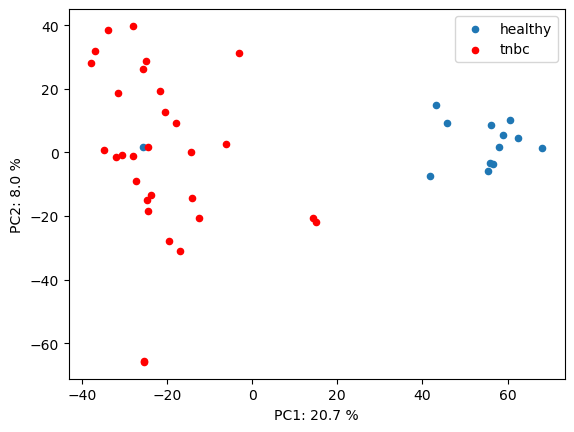

In [7]:
ax = df.loc[healthy,:].plot.scatter(0, 1)
df.loc[disease,:].plot.scatter(0, 1, color='r', ax=ax)
ax.set_xlabel(f'PC1: {100*pca.explained_variance_ratio_[0]:.1f} %')
ax.set_ylabel(f'PC2: {100*pca.explained_variance_ratio_[1]:.1f} %')
ax.legend(['healthy', 'tnbc'])

In [8]:
# remove outlier from further analysis
healthy = healthy[healthy != 'GSM952913']

## Vulcano plot

In [9]:
data['log2_FC'] = data.loc[:, disease].mean(axis=1) - data.loc[:, healthy].mean(axis=1)
data['p'] = data.apply(lambda x: ttest_ind(list(x[healthy]), list(x[disease]))[1], axis=1)
data['q'] = fdrcorrection(data['p'])[1]
data['log10_q'] = -np.log10(data['q'])

<Axes: xlabel='log2_FC', ylabel='log10_q'>

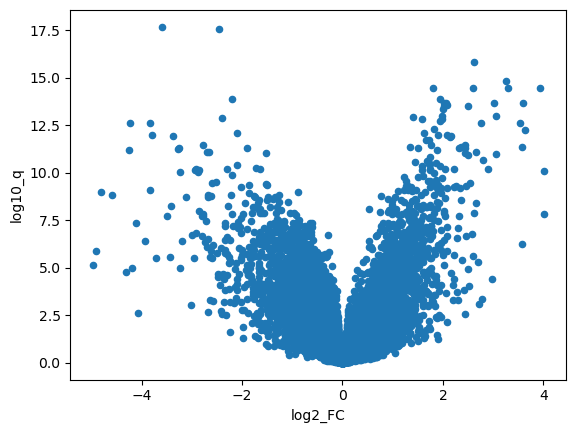

In [10]:
data.plot.scatter('log2_FC', 'log10_q')

## Pathway enrichment analysis

In [11]:
over_exp = list(data.query('log2_FC > 1 and q < 0.01')['Gene ID'])
under_exp = list(data.query('log2_FC < -1 and q < 0.01')['Gene ID'])

In [12]:
from gprofiler import GProfiler

gp = GProfiler(return_dataframe=True)
over = gp.profile(organism='hsapiens', query=over_exp)
under = gp.profile(organism='hsapiens', query=under_exp)

In [13]:
over.query('source == "KEGG" or source == "REAC"').sort_values('p_value').head(10)

,source,native,name,p_value,significant,description,term_size,query_size,intersection_size,effective_domain_size,precision,recall,query,parents
0,REAC,REAC:R-HSA-1640170,Cell Cycle,5.132192e-58,True,Cell Cycle,677,455,138,10916,0.303297,0.203840,query_1,[REAC:0000000]
1,REAC,REAC:R-HSA-69278,"Cell Cycle, Mitotic",6.964940e-57,True,"Cell Cycle, Mitotic",547,455,124,10916,0.272527,0.226691,query_1,[REAC:R-HSA-1640170]
2,REAC,REAC:R-HSA-69620,Cell Cycle Checkpoints,6.659488e-42,True,Cell Cycle Checkpoints,289,455,80,10916,0.175824,0.276817,query_1,[REAC:R-HSA-1640170]
7,REAC,REAC:R-HSA-68886,M Phase,2.336649e-35,True,M Phase,406,455,86,10916,0.189011,0.211823,query_1,[REAC:R-HSA-69278]
12,REAC,REAC:R-HSA-69306,DNA Replication,1.589734e-31,True,DNA Replication,187,455,57,10916,0.125275,0.304813,query_1,[REAC:0000000]
15,REAC,REAC:R-HSA-69481,G2/M Checkpoints,4.503131e-29,True,G2/M Checkpoints,167,455,52,10916,0.114286,0.311377,query_1,[REAC:R-HSA-69620]
21,REAC,REAC:R-HSA-774815,Nucleosome assembly,3.228356e-28,True,Nucleosome assembly,72,455,36,10916,0.079121,0.500000,query_1,[REAC:R-HSA-73886]
22,REAC,REAC:R-HSA-606279,Deposition of new CENPA-containing nucleosomes...,3.228356e-28,True,Deposition of new CENPA-containing nucleosomes...,72,455,36,10916,0.079121,0.500000,query_1,[REAC:R-HSA-774815]
26,REAC,REAC:R-HSA-69002,DNA Replication Pre-Initiation,5.513576e-26,True,DNA Replication Pre-Initiation,159,455,48,10916,0.105495,0.301887,query_1,[REAC:R-HSA-69306]
29,REAC,REAC:R-HSA-73886,Chromosome Maintenance,8.988602e-25,True,Chromosome Maintenance,138,455,44,10916,0.096703,0.318841,query_1,[REAC:R-HSA-1640170]


In [14]:
under.query('source == "KEGG" or source == "REAC"').sort_values('p_value').head(10)

,source,native,name,p_value,significant,description,term_size,query_size,intersection_size,effective_domain_size,precision,recall,query,parents
107,REAC,REAC:R-HSA-446107,Type I hemidesmosome assembly,0.000085,True,Type I hemidesmosome assembly,11,299,6,10916,0.020067,0.545455,query_1,[REAC:R-HSA-446728]
124,REAC,REAC:R-HSA-162582,Signal Transduction,0.000301,True,Signal Transduction,2548,299,107,10916,0.357860,0.041994,query_1,[REAC:0000000]
127,REAC,REAC:R-HSA-397014,Muscle contraction,0.000369,True,Muscle contraction,203,299,20,10916,0.066890,0.098522,query_1,[REAC:0000000]
219,KEGG,KEGG:04151,PI3K-Akt signaling pathway,0.007159,True,PI3K-Akt signaling pathway,356,240,24,8484,0.100000,0.067416,query_1,[KEGG:00000]
234,KEGG,KEGG:04068,FoxO signaling pathway,0.008755,True,FoxO signaling pathway,131,240,13,8484,0.054167,0.099237,query_1,[KEGG:00000]
235,REAC,REAC:R-HSA-445355,Smooth Muscle Contraction,0.009359,True,Smooth Muscle Contraction,43,299,8,10916,0.026756,0.186047,query_1,[REAC:R-HSA-397014]
274,KEGG,KEGG:05200,Pathways in cancer,0.019603,True,Pathways in cancer,527,240,30,8484,0.125000,0.056926,query_1,[KEGG:00000]
278,KEGG,KEGG:04510,Focal adhesion,0.020372,True,Focal adhesion,202,240,16,8484,0.066667,0.079208,query_1,[KEGG:00000]
313,KEGG,KEGG:01521,EGFR tyrosine kinase inhibitor resistance,0.039775,True,EGFR tyrosine kinase inhibitor resistance,79,240,9,8484,0.037500,0.113924,query_1,[KEGG:00000]
315,KEGG,KEGG:04270,Vascular smooth muscle contraction,0.040258,True,Vascular smooth muscle contraction,133,240,12,8484,0.050000,0.090226,query_1,[KEGG:00000]


## Metabolic reactions

In [15]:
recon3 = load_cbmodel('../mappings/Recon3D.xml.gz')

In [28]:
entrez = pd.read_csv('../mappings/Homo_sapiens.GRCh38.113.entrez.tsv', sep='\t', usecols=[0,3], header=0, dtype=str, names=['Gene ID', 'entrez'])

In [66]:
gpr = recon3.gene_to_reaction_lookup()
gpr = pd.DataFrame(gpr.items(), columns=['gene', 'reactions'])
gpr['entrez'] = gpr['gene'].apply(lambda x: x.split('_')[1])
gpr = pd.merge(entrez, gpr, on='entrez')

def merge_and_sort(x):
    return sorted({z for y in x for z in y})
    
gpr = gpr.groupby('Gene ID', as_index=False).agg({'reactions': merge_and_sort})

In [67]:
merged = pd.merge(data[['Gene ID', 'Gene Name', 'log2_FC', 'q']], gpr, on='Gene ID')

### up-regulated

In [91]:
up_rxns = merge_and_sort(merged.query('log2_FC > 2 and q < 0.01')['reactions'])

for r_id in up_rxns:
    print(recon3.reactions[r_id].name)
    recon3.print_reaction(r_id, use_names=True)
    print()

Desaturation of Myristic Acid to 9-Tetradecenoic Acid
R_DESAT14_9: H+ + Nicotinamide adenine dinucleotide - reduced + O2 O2 + Tetradecanoyl-CoA (n-C14:0CoA) --> 2.0 H2O H2O + Nicotinamide adenine dinucleotide + Tetradecenoyl Coenzyme A (N-C14:1)

Fatty acyl-CoA desaturase (n-C18:2CoA -> n-C18:3CoA)
R_DESAT18_10: H+ + Alpha-Linolenoyl-CoA + Nicotinamide adenine dinucleotide - reduced + O2 O2 --> 2.0 H2O H2O + Nicotinamide adenine dinucleotide + Stearidonyl coenzyme A

Fatty Acyl Coenzyme A Desaturase (N-C18:1CoA -> N-C18:2CoA)
R_DESAT18_12: H+ + Nicotinamide adenine dinucleotide - reduced + O2 O2 + 11-Octadecenoyl Coenzyme A --> 2.0 H2O H2O + Linoelaidyl coenzyme A + Nicotinamide adenine dinucleotide

Fatty acyl-CoA desaturase (n-C18:1CoA -> n-C18:2CoA)
R_DESAT18_6: H+ + Nicotinamide adenine dinucleotide - reduced + O2 O2 + Octadecenoyl-CoA (n-C18:1CoA) --> 2.0 H2O H2O + Linoelaidyl coenzyme A + Nicotinamide adenine dinucleotide

Fatty acyl-CoA desaturase (n-C18:1CoA -> n-C18:2CoA)
R_DE

### down-regulated

In [89]:
down_rxns = merge_and_sort(merged.query('log2_FC < -2 and q < 0.01')['reactions'])

for r_id in down_rxns:
    print(recon3.reactions[r_id].name)
    recon3.print_reaction(r_id, use_names=True)
    print()

Adenylate kinase
R_ADK1: AMP C10H12N5O7P + ATP C10H12N5O13P3 <-> 2.0 ADP C10H12N5O10P2

Adentylate kinase (GTP)
R_ADK3: AMP C10H12N5O7P + GTP C10H12N5O14P3 <-> ADP C10H12N5O10P2 + GDP C10H12N5O11P2

Adenylate kinase (d form)
R_ADKd: DAMP C10H12N5O6P + DATP C10H12N5O12P3 <-> 2.0 DADP C10H12N5O9P2

Cytidylate kinase (CMP)(GTP)
R_CYTK3: CMP C9H12N3O8P + GTP C10H12N5O14P3 <-> CDP C9H12N3O11P2 + GDP C10H12N5O11P2

Cytidylate kinase (dCMP)(GTP)
R_CYTK4: DCMP C9H12N3O7P + GTP C10H12N5O14P3 <-> DCDP C9H12N3O10P2 + GDP C10H12N5O11P2

Deoxyadenylate kinase
R_DADK: ATP C10H12N5O13P3 + DAMP C10H12N5O6P <-> ADP C10H12N5O10P2 + DADP C10H12N5O9P2

Ferric iron uptake, plasma membrane
R_FE3t: Iron (Fe3+) <-> Iron (Fe3+) [-inf, 0.0]

Hydroxymethylglutaryl CoA synthase  mitochondrial
R_HMGCOASm: Coenzyme A + H+ + Hydroxymethylglutaryl CoA C27H39N7O20P3S <-> Acetoacetyl-CoA + Acetyl-CoA + H2O H2O [-inf, 0.0]

Phosphatidylinositol 4-phosphate 3-kinase
R_PI4P3K: ATP C10H12N5O13P3 + 1-Phosphatidyl-1D-myo-ino